## Example 1:
- Training set: 15 eigenstates, 2000 time steps in [0, 4 * $\pi$]
- System settings: x = [-6, 6], 150 grid points
- train_loss 3.7431e-05, test_loss 3.5646e-05,

In [153]:
from tdksnn import TDKSNN
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch, time, sys
from matplotlib.animation import FuncAnimation
from scipy.integrate import odeint

In [154]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [173]:
x_min = -6
x_max = 6
sys_size = 150
line_x = np.linspace(x_min, x_max, sys_size)
x = {}
dx = line_x[1] - line_x[0]
KS_coef = np.genfromtxt('./data/ho_wf_15_2.csv', dtype=complex)
KS_coef_dt = np.genfromtxt('./data/ho_wf_dt_15_2.csv', dtype=complex)

q = np.real(KS_coef)
p = np.imag(KS_coef)
dqdt = np.real(KS_coef_dt)
dpdt = np.imag(KS_coef_dt)

x['x'] = np.hstack((q, p))
x['dx'] = np.hstack((dqdt, dpdt))
split_ix = int(len(x['x']) * 0.95)
split_data = {}
for k in ['x', 'dx']:
    split_data[k], split_data['test_' + k] = x[k][:split_ix], x[k][split_ix:]
x = split_data
EXPERIMENT_DIR = '.'

def get_args():
    return {'input_dim': 2*150,
         'hidden_dim': 400,
         'learn_rate': 3e-4,
         'batch_size': 200,
         'nonlinearity': 'softplus',
         'total_steps': 10000,
         'print_every': 50,
         'verbose': True,
         'name': 'ho_sftplus_15_2',
         'seed': 0,
         'save_dir': '{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

def load_model(args):
    output_dim = 1
    model = TDKSNN(args.input_dim, args.hidden_dim, output_dim, nonlinearity=args.nonlinearity,nn_type='fc')
    model.double()
    path = "{}/{}.tar".format(args.save_dir, args.name)
    model.load_state_dict(torch.load(path,map_location=torch.device(device)))
    return model

args = ObjectView(get_args())
ho_model = load_model(args)
y0 = np.vstack((x['x'],x['test_x']))

<IPython.core.display.Javascript object>


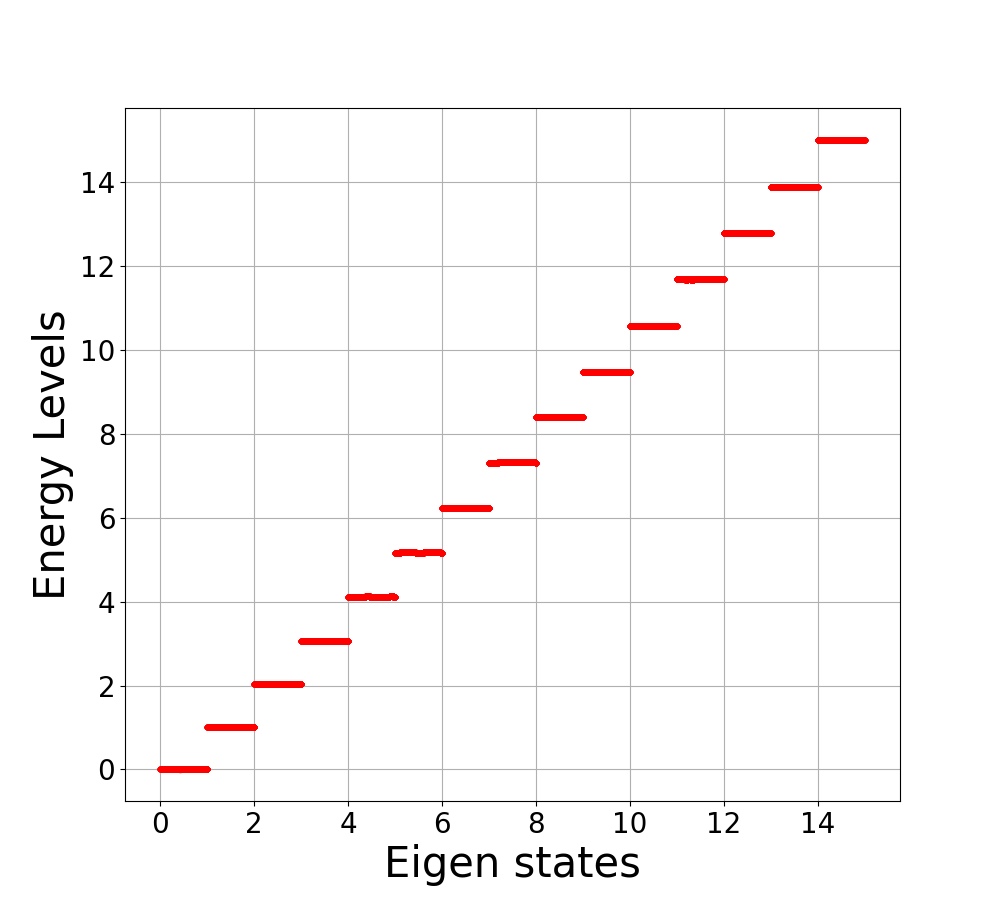

In [174]:
fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
res = []
for k in range(30000):
    c = torch.tensor(np.sqrt(2) * y0[k], requires_grad=True, dtype=torch.float64)
    res.append(ho_model(c).detach().numpy())
res = np.array(res)
a = res * dx
x_axis = np.linspace(0,29999,30000)
ax.plot(x_axis / 2000, a - a[0],'r.')
# plt.legend(prop={'size':20})
plt.xlabel("Eigen states")
plt.ylabel("Energy Levels")
ax.xaxis.label.set_size(30)
ax.yaxis.label.set_size(30)
plt.tick_params(labelsize=20)
plt.grid()
plt.show()
plt.savefig("./plots/lvls_15eigen_xmax6_150pts.png")

<IPython.core.display.Javascript object>


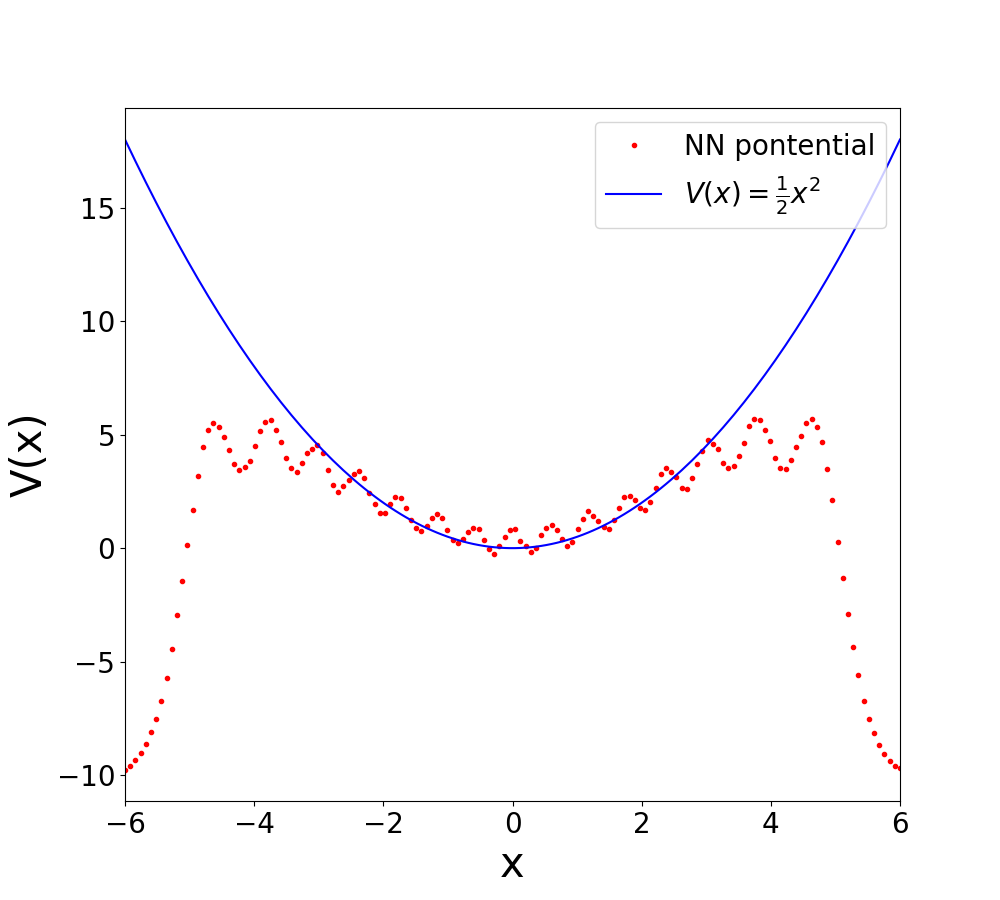

In [176]:
k=0
c = torch.tensor(np.sqrt(2) * y0[k], requires_grad=True, dtype=torch.float64)
v = torch.autograd.functional.hessian(ho_model,c)

v_diag = np.diag(v.numpy())
vv = v_diag[0:150] + v_diag[150:]
plt.rcParams['text.usetex']=False
fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.plot(line_x, 0.5*(vv / dx - min(vv[20:80]/dx) -0.5), 'r.', label='NN pontential')
ax.plot(line_x, 0.5 * line_x**2, 'b-',label=r'$V(x) = \frac{1}{2}x^2$')
ax.legend(loc='upper right',prop={'size':20})
plt.xlim(-6,6)
#plt.ylim(-2,10)
plt.xlabel("x")
plt.ylabel("V(x)")
ax.xaxis.label.set_size(30)
ax.yaxis.label.set_size(30)
plt.tick_params(labelsize=20)
plt.show()
plt.savefig("./plots/V_15eigen_xmax6_150pts.png")

<IPython.core.display.Javascript object>


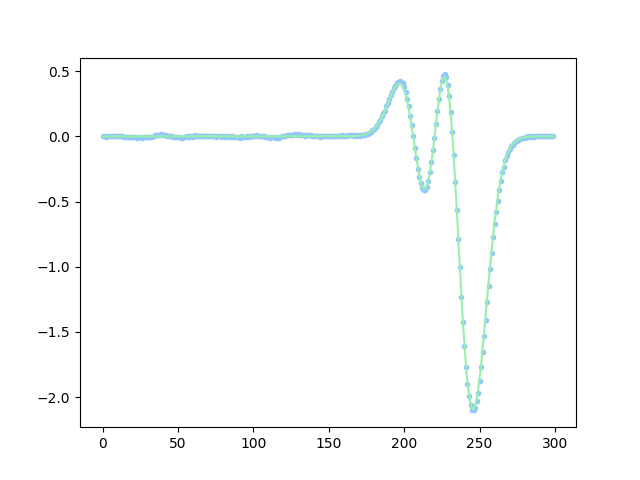

In [117]:
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
import numpy.polynomial.hermite as Herm
import math
import numpy
m=1.
w=1.
hbar=1.
#Discretized space

x_lim = 6
x = np.linspace(-x_lim, x_lim, 150)
dx = x[1] - x[0]
def hermite(x, n):
    xi = numpy.sqrt(m*w/hbar)*x
    herm_coeffs = numpy.zeros(n+1)
    herm_coeffs[n] = 1
    return Herm.hermval(xi, herm_coeffs)
  
def stationary_state(x,n):
    xi = numpy.sqrt(m*w/hbar)*x
    prefactor = 1./math.sqrt(2.**n * math.factorial(n)) * (m*w/(numpy.pi*hbar))**(0.25)
    psi = prefactor * numpy.exp(- xi**2 / 2) * hermite(x,n)
    return psi

T = np.linspace(0,30,30000)
psi_0 = stationary_state(x,0)
psi_1 = stationary_state(x,1)
psi_2 = stationary_state(x,2)
psi_3 = stationary_state(x,3)
init_wf = 1 / np.sqrt(2) * psi_0 + 1 / 2 * psi_1 + 1 / np.sqrt(6) * psi_2 + 1 / np.sqrt(12) * psi_3
def E_n(n):
    return (n + 1/2)*w
wf_t = []
wf_dt = []
for t in T:
    wf_t.append(1 / np.sqrt(2) * psi_0 * np.exp(-1j*E_n(0)*t) + 1 / 2 * psi_1* np.exp(-1j*E_n(1)*t) + 1 / np.sqrt(6) * psi_2* np.exp(-1j*E_n(2)*t) + 1 / np.sqrt(12) * psi_3* np.exp(-1j*E_n(3)*t))
    wf_dt.append(1 / np.sqrt(2) * -1j*E_n(0)*psi_0 * np.exp(-1j*E_n(0)*t) + -1j*E_n(1)*1 / 2 * psi_1* np.exp(-1j*E_n(1)*t) + -1j*E_n(2)*1 / np.sqrt(6) * psi_2* np.exp(-1j*E_n(2)*t) + -1j*E_n(3)*1 / np.sqrt(12) * psi_3* np.exp(-1j*E_n(3)*t))
    

qq = np.real(wf_t)
pp = np.imag(wf_t)
q_p = torch.tensor(np.hstack((qq, pp)),
                         requires_grad=True, dtype=torch.float32).to(device)
q_dt = np.real(wf_dt)
p_dt = np.imag(wf_dt)
q_p_dt = torch.tensor(np.hstack((q_dt, p_dt)),
                         requires_grad=True, dtype=torch.float32).to(device)

k= 0
ho_model = ho_model.float().to(device)
ho_dt = ho_model.time_derivative(np.sqrt(2)*q_p[k]).cpu().detach().numpy()
comp = np.sqrt(2)*q_p_dt[k].cpu().detach().numpy()
# plt.plot(q_p[k].detach().numpy())
plt.plot(ho_dt,'.')
plt.plot(comp)

<IPython.core.display.Javascript object>


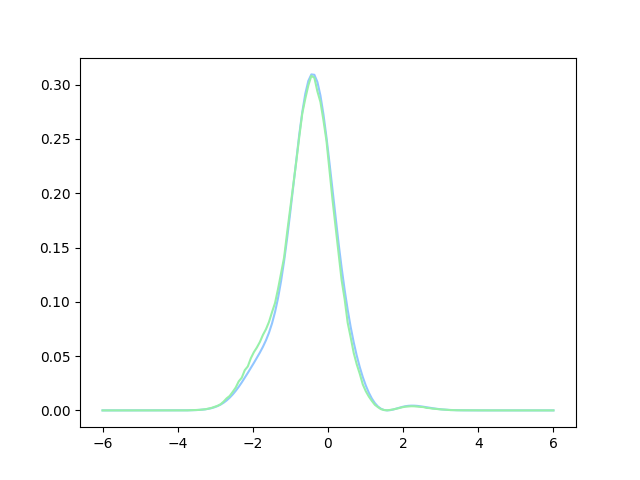

In [118]:
import scipy
solve_ivp = scipy.integrate.solve_ivp
def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).to(device)
        dx = model.time_derivative(np.sqrt(2)*x).data.cpu().numpy()
        return dx / np.sqrt(2)

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

def integrate_models(x0, t_span=[0,15], t_eval=None):
    kwargs = {'t_eval': t_eval, 'rtol': 1e-12}
    hnn_path = integrate_model(ho_model, t_span, x0, **kwargs)
    hnn_x = hnn_path['y'].T
    
    return hnn_x

t_span=[0,30]
x0 = q_p[0].cpu().detach().numpy()
t_eval = np.linspace(t_span[0], t_span[1], 30000)
hnn_x = integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)

k = 2000
dens = 0.5*(q_p[:,0:150].cpu()**2 + q_p[:, 150:].cpu()**2)
dens_nn = 0.5 * (hnn_x[:,0:150]**2 + hnn_x[:,150:]**2) 
plt.plot(line_x, dens[k].detach().numpy())
plt.plot(line_x,dens_nn[k])

<IPython.core.display.Javascript object>


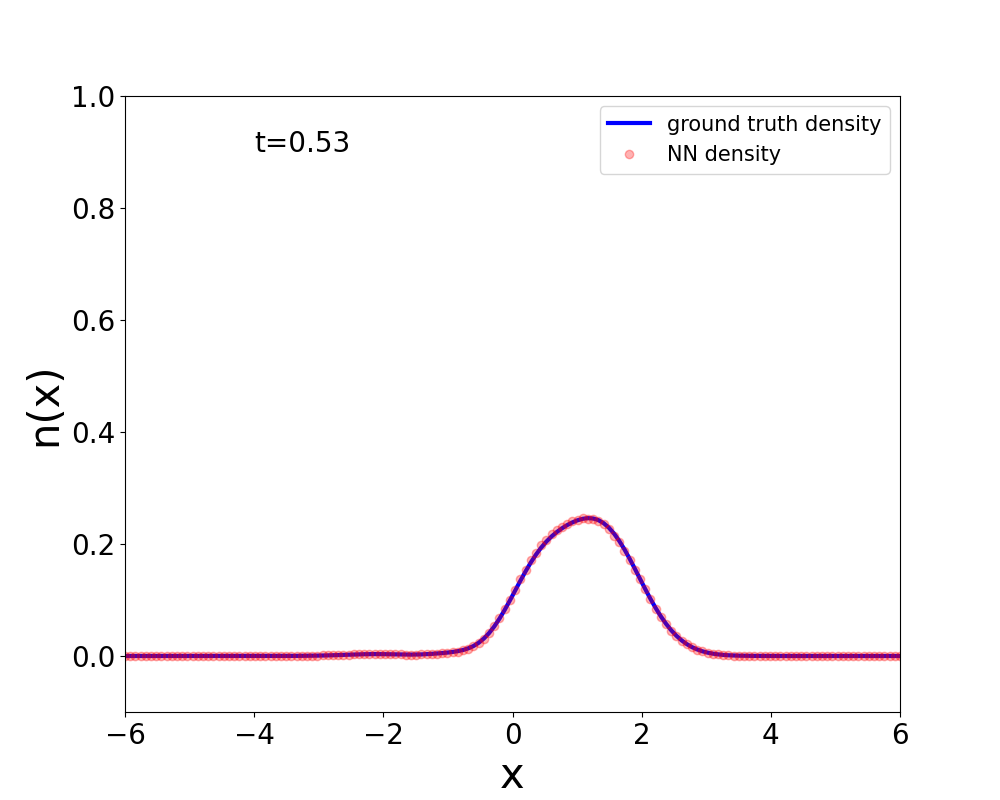

In [150]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
# plt.style.use('seaborn-pastel')
# matplotlib.rcParams['animation.embed_limit'] = 2**128
length = 150
xmax = 6
dens = 0.5*(q_p[:,0:length].cpu()**2 + q_p[:, length:].cpu()**2)
dens = dens.detach().numpy()
dens_nn = 0.5 * (hnn_x[:,0:length]**2 + hnn_x[:,length:]**2) 
fig = plt.figure(figsize=(10,8))
ax = plt.axes(xlim=(-xmax, xmax), ylim=(-0.1, 1))

x = np.linspace(-6, 6, length)
line, = ax.plot(x, dens[0,:], 'b', lw= 3, label='ground truth density')
line2, = ax.plot(x, dens_nn[0,:], 'ro', alpha=0.3, label='NN density' )
time_text = ax.text(-4,0.9,s='0', fontsize=20)
def init():
    x = np.linspace(-xmax, xmax, length)
    line.set_data(x, dens[0,:])
    line2.set_data(x, dens_nn[0,:])
    
    return line, line2,
def animate(i):
    x = np.linspace(-xmax, xmax, length)
    y = dens[i,:]
    z = dens_nn[i,:]
    line.set_data(x, y)
    line2.set_data(x, z)
    time_text.set_text('t={0:.2f}'.format(t_eval[i]))
    return line, line2, time_text,

ax.legend(loc='upper right',prop={'size':15})
ax.xaxis.label.set_size(30)
ax.yaxis.label.set_size(30)
plt.tick_params(labelsize=20)
plt.xlabel("x")
plt.ylabel("n(x)")
anim = FuncAnimation(fig, animate, init_func=init,
                               frames=2000, interval=1, blit=True)

# from IPython.display import HTML
# HTML(anim.to_jshtml())

## Example 2:
- Training set: 15 eigenstates, 2000 time steps in [0, 4 * $\pi$]
- System settings: x = [-8, 8], 100 grid points

In [168]:
x_min = -8
x_max = 8
sys_size = 100
line_x = np.linspace(x_min, x_max, sys_size)
x = {}
dx = line_x[1] - line_x[0]
KS_coef = np.genfromtxt('./data/ho_wf_15.csv', dtype=complex)
KS_coef_dt = np.genfromtxt('./data/ho_wf_dt_15.csv', dtype=complex)

q = np.real(KS_coef)
p = np.imag(KS_coef)
dqdt = np.real(KS_coef_dt)
dpdt = np.imag(KS_coef_dt)

x['x'] = np.hstack((q, p))
x['dx'] = np.hstack((dqdt, dpdt))
split_ix = int(len(x['x']) * 0.95)
split_data = {}
for k in ['x', 'dx']:
    split_data[k], split_data['test_' + k] = x[k][:split_ix], x[k][split_ix:]
x = split_data
EXPERIMENT_DIR = '.'

def get_args():
    return {'input_dim': 2*100,
         'hidden_dim': 400,
         'learn_rate': 3e-4,
         'batch_size': 200,
         'nonlinearity': 'softplus',
         'total_steps': 10000,
         'print_every': 50,
         'verbose': True,
         'name': 'ho_sftplus_15',
         'seed': 0,
         'save_dir': '{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

def load_model(args):
    output_dim = 1
    model = TDKSNN(args.input_dim, args.hidden_dim, output_dim, nonlinearity=args.nonlinearity,nn_type='fc')
    model.double()
    path = "{}/{}.tar".format(args.save_dir, args.name)
    model.load_state_dict(torch.load(path,map_location=torch.device(device)))
    return model

args = ObjectView(get_args())
ho_model = load_model(args)
y0 = np.vstack((x['x'],x['test_x']))

<IPython.core.display.Javascript object>


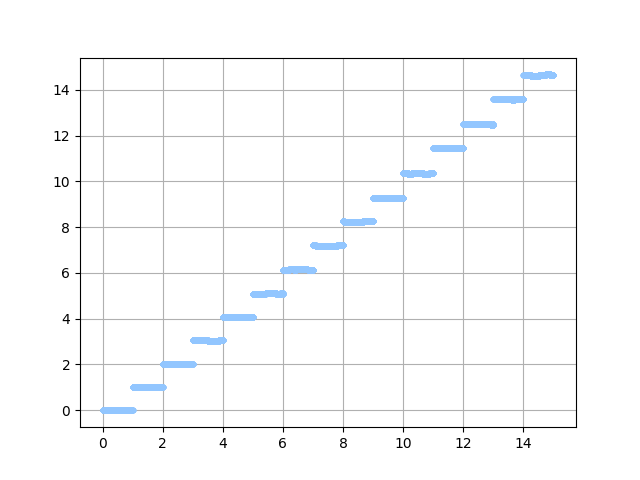

In [169]:
res = []
for k in range(30000):
    c = torch.tensor(np.sqrt(2) * y0[k], requires_grad=True, dtype=torch.float64)
    res.append(ho_model(c).detach().numpy())
res = np.array(res)
a = res * dx
x_axis = np.linspace(0,29999,30000)
plt.plot(x_axis / 2000, a - a[0],'.')
plt.grid()

<IPython.core.display.Javascript object>


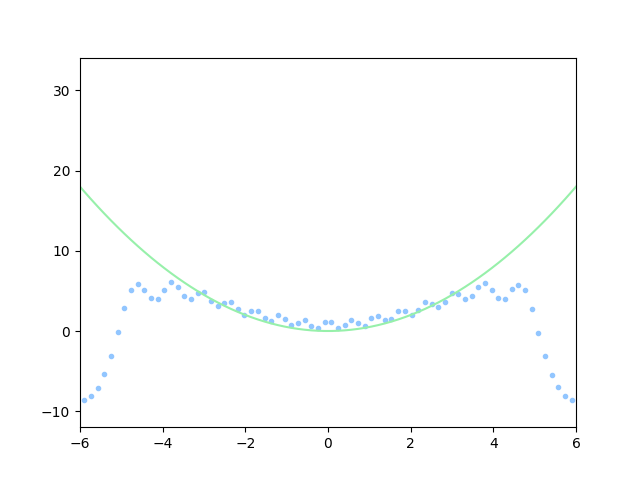

In [171]:
k=0
c = torch.tensor(np.sqrt(2) * y0[k], requires_grad=True, dtype=torch.float64)
v = torch.autograd.functional.hessian(ho_model,c)

v_diag = np.diag(v.numpy())
vv = v_diag[0:100] + v_diag[100:]
plt.plot(line_x, 0.5*(vv / dx - min(vv/dx) - 19.8), '.')
plt.plot(line_x, 0.5 * line_x**2)
plt.xlim(-6,6)
# plt.ylim(-2,10)
plt.show()

<IPython.core.display.Javascript object>


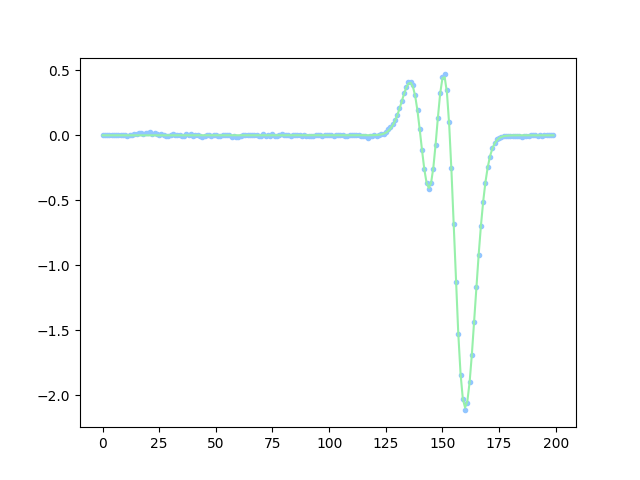

In [29]:
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
import numpy.polynomial.hermite as Herm
import math
import numpy
m=1.
w=1.
hbar=1.
#Discretized space

x_lim = 8
x = np.linspace(-x_lim, x_lim, 100)
dx = x[1] - x[0]
def hermite(x, n):
    xi = numpy.sqrt(m*w/hbar)*x
    herm_coeffs = numpy.zeros(n+1)
    herm_coeffs[n] = 1
    return Herm.hermval(xi, herm_coeffs)
  
def stationary_state(x,n):
    xi = numpy.sqrt(m*w/hbar)*x
    prefactor = 1./math.sqrt(2.**n * math.factorial(n)) * (m*w/(numpy.pi*hbar))**(0.25)
    psi = prefactor * numpy.exp(- xi**2 / 2) * hermite(x,n)
    return psi

T = np.linspace(0,30,30000)
psi_0 = stationary_state(x,0)
psi_1 = stationary_state(x,1)
psi_2 = stationary_state(x,2)
psi_3 = stationary_state(x,3)
init_wf = 1 / np.sqrt(2) * psi_0 + 1 / 2 * psi_1 + 1 / np.sqrt(6) * psi_2 + 1 / np.sqrt(12) * psi_3
def E_n(n):
    return (n + 1/2)*w
wf_t = []
wf_dt = []
for t in T:
    wf_t.append(1 / np.sqrt(2) * psi_0 * np.exp(-1j*E_n(0)*t) + 1 / 2 * psi_1* np.exp(-1j*E_n(1)*t) + 1 / np.sqrt(6) * psi_2* np.exp(-1j*E_n(2)*t) + 1 / np.sqrt(12) * psi_3* np.exp(-1j*E_n(3)*t))
    wf_dt.append(1 / np.sqrt(2) * -1j*E_n(0)*psi_0 * np.exp(-1j*E_n(0)*t) + -1j*E_n(1)*1 / 2 * psi_1* np.exp(-1j*E_n(1)*t) + -1j*E_n(2)*1 / np.sqrt(6) * psi_2* np.exp(-1j*E_n(2)*t) + -1j*E_n(3)*1 / np.sqrt(12) * psi_3* np.exp(-1j*E_n(3)*t))
    

qq = np.real(wf_t)
pp = np.imag(wf_t)
q_p = torch.tensor(np.hstack((qq, pp)),
                         requires_grad=True, dtype=torch.float32).to(device)
q_dt = np.real(wf_dt)
p_dt = np.imag(wf_dt)
q_p_dt = torch.tensor(np.hstack((q_dt, p_dt)),
                         requires_grad=True, dtype=torch.float32).to(device)

k= 0
ho_model = ho_model.float().to(device)
ho_dt = ho_model.time_derivative(np.sqrt(2)*q_p[k]).cpu().detach().numpy()
comp = np.sqrt(2)*q_p_dt[k].cpu().detach().numpy()
# plt.plot(q_p[k].detach().numpy())
plt.plot(ho_dt,'.')
plt.plot(comp)

<IPython.core.display.Javascript object>


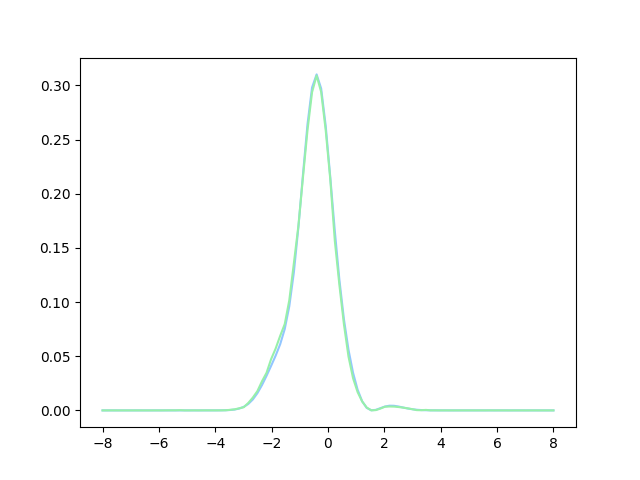

In [31]:
import scipy
solve_ivp = scipy.integrate.solve_ivp
def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).to(device)
        dx = model.time_derivative(np.sqrt(2)*x).data.cpu().numpy()
        return dx / np.sqrt(2)

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

def integrate_models(x0, t_span=[0,15], t_eval=None):
    kwargs = {'t_eval': t_eval, 'rtol': 1e-12}
    hnn_path = integrate_model(ho_model, t_span, x0, **kwargs)
    hnn_x = hnn_path['y'].T
    
    return hnn_x

t_span=[0,30]
x0 = q_p[0].cpu().detach().numpy()
t_eval = np.linspace(t_span[0], t_span[1], 30000)
hnn_x = integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)

k = 2000
dens = 0.5*(q_p[:,0:100].cpu()**2 + q_p[:, 100:].cpu()**2)
dens_nn = 0.5 * (hnn_x[:,0:100]**2 + hnn_x[:,100:]**2) 
plt.plot(line_x, dens[k].detach().numpy())
plt.plot(line_x,dens_nn[k])

<IPython.core.display.Javascript object>


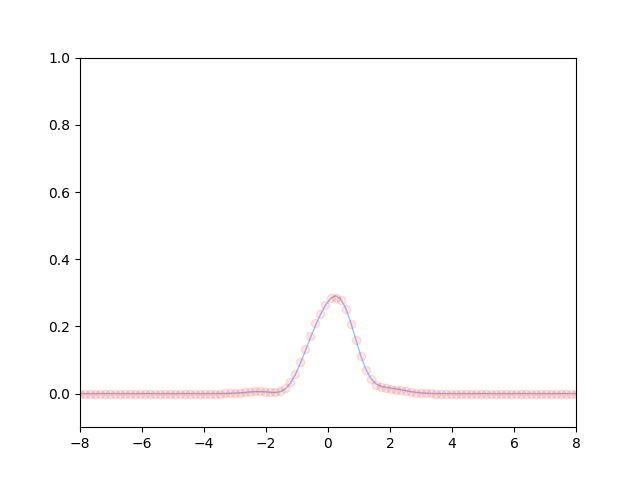

In [32]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
# plt.style.use('seaborn-pastel')
# matplotlib.rcParams['animation.embed_limit'] = 2**128

length = 100
xmax = 8
dens = 0.5*(q_p[:,0:length].cpu()**2 + q_p[:, length:].cpu()**2)
dens = dens.detach().numpy()
dens_nn = 0.5 * (hnn_x[:,0:length]**2 + hnn_x[:,length:]**2) 
fig = plt.figure()
ax = plt.axes(xlim=(-xmax, xmax), ylim=(-0.1, 1))

x = np.linspace(-6, 6, length)
line, = ax.plot(x, dens[0,:], lw= 1)
line2, = ax.plot(x, dens_nn[0,:], 'ro', alpha=0.1)
def init():
    x = np.linspace(-xmax, xmax, length)
    line.set_data(x, dens[0,:])
    line2.set_data(x, dens_nn[0,:])
    return line, line2,
def animate(i):
    x = np.linspace(-xmax, xmax, length)
    y = dens[i,:]
    z = dens_nn[i,:]
    line.set_data(x, y)
    line2.set_data(x, z)
    return line, line2,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=4000, interval=1, blit=True)

# from IPython.display import HTML
# HTML(anim.to_jshtml())

## Example 3:
- Training set: 10 eigenstates, 2000 time steps in [0, 4 * $\pi$]
- System settings: x = [-4, 4], 100 grid points

In [35]:
x_min = -4
x_max = 4
sys_size = 100
line_x = np.linspace(x_min, x_max, sys_size)
x = {}
dx = line_x[1] - line_x[0]
KS_coef = np.genfromtxt('./data/ho_wf.csv', dtype=complex)
KS_coef_dt = np.genfromtxt('./data/ho_wf_dt.csv', dtype=complex)

q = np.real(KS_coef)
p = np.imag(KS_coef)
dqdt = np.real(KS_coef_dt)
dpdt = np.imag(KS_coef_dt)

x['x'] = np.hstack((q, p))
x['dx'] = np.hstack((dqdt, dpdt))
split_ix = int(len(x['x']) * 0.95)
split_data = {}
for k in ['x', 'dx']:
    split_data[k], split_data['test_' + k] = x[k][:split_ix], x[k][split_ix:]
x = split_data
EXPERIMENT_DIR = '.'

def get_args():
    return {'input_dim': 2*100,
         'hidden_dim': 400,
         'learn_rate': 3e-4,
         'batch_size': 200,
         'nonlinearity': 'softplus',
         'total_steps': 10000,
         'print_every': 50,
         'verbose': True,
         'name': 'ho_sftplus',
         'seed': 0,
         'save_dir': '{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

def load_model(args):
    output_dim = 1
    model = TDKSNN(args.input_dim, args.hidden_dim, output_dim, nonlinearity=args.nonlinearity,nn_type='fc')
    model.double()
    path = "{}/{}.tar".format(args.save_dir, args.name)
    model.load_state_dict(torch.load(path,map_location=torch.device(device)))
    return model

args = ObjectView(get_args())
ho_model = load_model(args)
y0 = np.vstack((x['x'],x['test_x']))

<IPython.core.display.Javascript object>


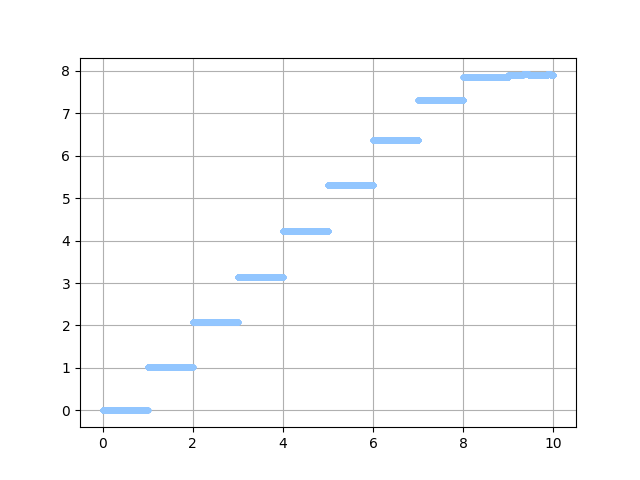

In [37]:
res = []
length = 20000
for k in range(length):
    c = torch.tensor(np.sqrt(2) * y0[k], requires_grad=True, dtype=torch.float64)
    res.append(ho_model(c).detach().numpy())
res = np.array(res)
a = res * dx
x_axis = np.linspace(0,length - 1,length)
plt.plot(x_axis / 2000, a - a[0],'.')
plt.grid()

<IPython.core.display.Javascript object>


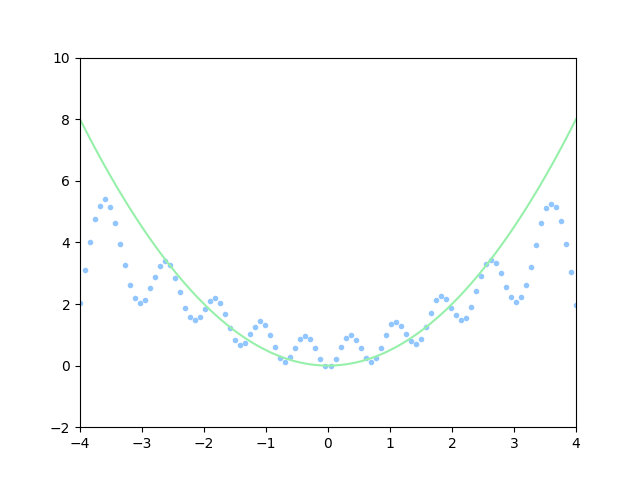

In [39]:
k=0
c = torch.tensor(np.sqrt(2) * y0[k], requires_grad=True, dtype=torch.float64)
v = torch.autograd.functional.hessian(ho_model,c)

v_diag = np.diag(v.numpy())
vv = v_diag[0:100] + v_diag[100:]
plt.plot(line_x, 0.5*(vv / dx - min(vv/dx)), '.')
plt.plot(line_x, 0.5 * line_x**2)
plt.xlim(-4,4)
plt.ylim(-2,10)
plt.show()

<IPython.core.display.Javascript object>


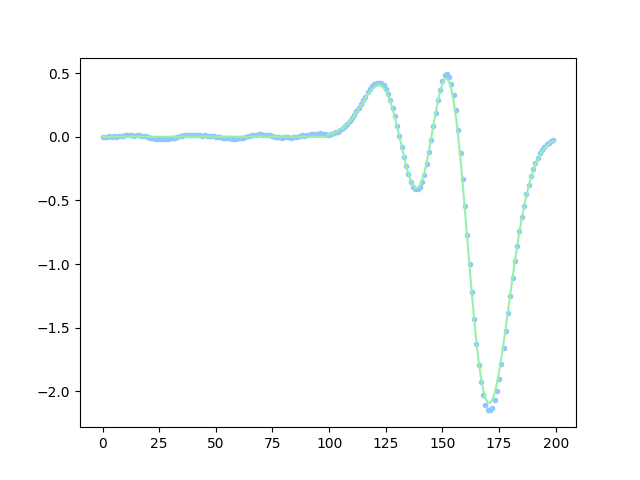

In [41]:
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
import numpy.polynomial.hermite as Herm
import math
import numpy
m=1.
w=1.
hbar=1.
#Discretized space

x_lim = 4
x = np.linspace(-x_lim, x_lim, 100)
dx = x[1] - x[0]
def hermite(x, n):
    xi = numpy.sqrt(m*w/hbar)*x
    herm_coeffs = numpy.zeros(n+1)
    herm_coeffs[n] = 1
    return Herm.hermval(xi, herm_coeffs)
  
def stationary_state(x,n):
    xi = numpy.sqrt(m*w/hbar)*x
    prefactor = 1./math.sqrt(2.**n * math.factorial(n)) * (m*w/(numpy.pi*hbar))**(0.25)
    psi = prefactor * numpy.exp(- xi**2 / 2) * hermite(x,n)
    return psi

T = np.linspace(0,30,30000)
psi_0 = stationary_state(x,0)
psi_1 = stationary_state(x,1)
psi_2 = stationary_state(x,2)
psi_3 = stationary_state(x,3)
init_wf = 1 / np.sqrt(2) * psi_0 + 1 / 2 * psi_1 + 1 / np.sqrt(6) * psi_2 + 1 / np.sqrt(12) * psi_3
def E_n(n):
    return (n + 1/2)*w
wf_t = []
wf_dt = []
for t in T:
    wf_t.append(1 / np.sqrt(2) * psi_0 * np.exp(-1j*E_n(0)*t) + 1 / 2 * psi_1* np.exp(-1j*E_n(1)*t) + 1 / np.sqrt(6) * psi_2* np.exp(-1j*E_n(2)*t) + 1 / np.sqrt(12) * psi_3* np.exp(-1j*E_n(3)*t))
    wf_dt.append(1 / np.sqrt(2) * -1j*E_n(0)*psi_0 * np.exp(-1j*E_n(0)*t) + -1j*E_n(1)*1 / 2 * psi_1* np.exp(-1j*E_n(1)*t) + -1j*E_n(2)*1 / np.sqrt(6) * psi_2* np.exp(-1j*E_n(2)*t) + -1j*E_n(3)*1 / np.sqrt(12) * psi_3* np.exp(-1j*E_n(3)*t))
    

qq = np.real(wf_t)
pp = np.imag(wf_t)
q_p = torch.tensor(np.hstack((qq, pp)),
                         requires_grad=True, dtype=torch.float32).to(device)
q_dt = np.real(wf_dt)
p_dt = np.imag(wf_dt)
q_p_dt = torch.tensor(np.hstack((q_dt, p_dt)),
                         requires_grad=True, dtype=torch.float32).to(device)

k= 0
ho_model = ho_model.float().to(device)
ho_dt = ho_model.time_derivative(np.sqrt(2)*q_p[k]).cpu().detach().numpy()
comp = np.sqrt(2)*q_p_dt[k].cpu().detach().numpy()
# plt.plot(q_p[k].detach().numpy())
plt.plot(ho_dt,'.')
plt.plot(comp)

<IPython.core.display.Javascript object>


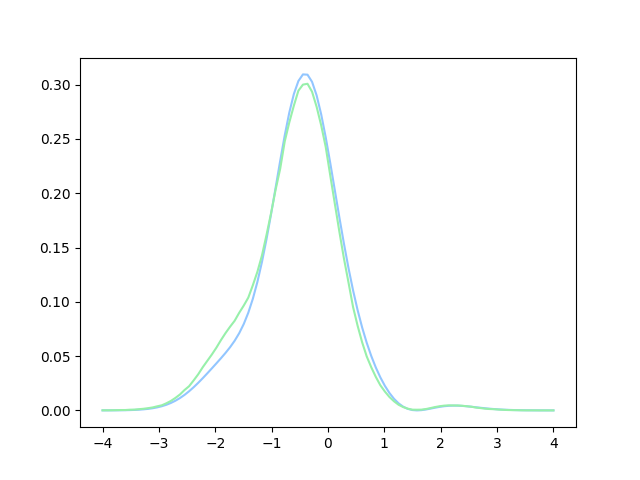

In [42]:
import scipy
solve_ivp = scipy.integrate.solve_ivp
def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).to(device)
        dx = model.time_derivative(np.sqrt(2)*x).data.cpu().numpy()
        return dx / np.sqrt(2)

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

def integrate_models(x0, t_span=[0,15], t_eval=None):
    kwargs = {'t_eval': t_eval, 'rtol': 1e-12}
    hnn_path = integrate_model(ho_model, t_span, x0, **kwargs)
    hnn_x = hnn_path['y'].T
    
    return hnn_x

t_span=[0,30]
x0 = q_p[0].cpu().detach().numpy()
t_eval = np.linspace(t_span[0], t_span[1], 30000)
hnn_x = integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)

k = 2000
dens = 0.5*(q_p[:,0:100].cpu()**2 + q_p[:, 100:].cpu()**2)
dens_nn = 0.5 * (hnn_x[:,0:100]**2 + hnn_x[:,100:]**2) 
plt.plot(line_x, dens[k].detach().numpy())
plt.plot(line_x,dens_nn[k])

<IPython.core.display.Javascript object>


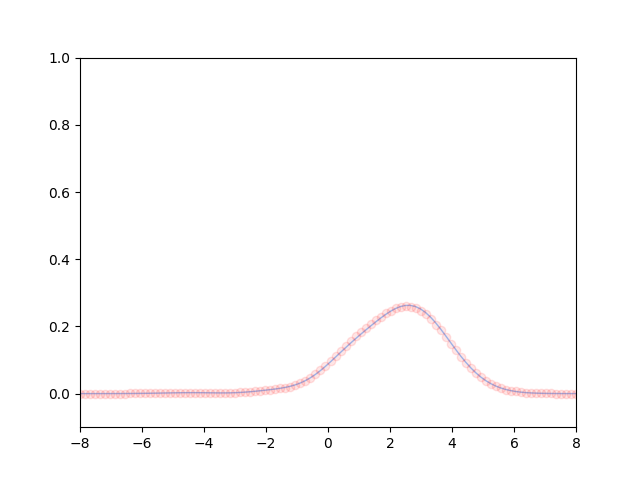

In [43]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
# plt.style.use('seaborn-pastel')
# matplotlib.rcParams['animation.embed_limit'] = 2**128

length = 100
xmax = 8
dens = 0.5*(q_p[:,0:length].cpu()**2 + q_p[:, length:].cpu()**2)
dens = dens.detach().numpy()
dens_nn = 0.5 * (hnn_x[:,0:length]**2 + hnn_x[:,length:]**2) 
fig = plt.figure()
ax = plt.axes(xlim=(-xmax, xmax), ylim=(-0.1, 1))

x = np.linspace(-6, 6, length)
line, = ax.plot(x, dens[0,:], lw= 1)
line2, = ax.plot(x, dens_nn[0,:], 'ro', alpha=0.1)
def init():
    x = np.linspace(-xmax, xmax, length)
    line.set_data(x, dens[0,:])
    line2.set_data(x, dens_nn[0,:])
    return line, line2,
def animate(i):
    x = np.linspace(-xmax, xmax, length)
    y = dens[i,:]
    z = dens_nn[i,:]
    line.set_data(x, y)
    line2.set_data(x, z)
    return line, line2,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=4000, interval=1, blit=True)

# from IPython.display import HTML
# HTML(anim.to_jshtml())

## Example 4:
- Training set: 5 eigenstates, 2000 time steps in [0, 4 * $\pi$]
- System settings: x = [-4, 4], 100 grid points

In [45]:
x_min = -4
x_max = 4
sys_size = 100
line_x = np.linspace(x_min, x_max, sys_size)
x = {}
dx = line_x[1] - line_x[0]
KS_coef = np.genfromtxt('./data/ho_wf_5.csv', dtype=complex)
KS_coef_dt = np.genfromtxt('./data/ho_wf_dt_5.csv', dtype=complex)

q = np.real(KS_coef)
p = np.imag(KS_coef)
dqdt = np.real(KS_coef_dt)
dpdt = np.imag(KS_coef_dt)

x['x'] = np.hstack((q, p))
x['dx'] = np.hstack((dqdt, dpdt))
split_ix = int(len(x['x']) * 0.95)
split_data = {}
for k in ['x', 'dx']:
    split_data[k], split_data['test_' + k] = x[k][:split_ix], x[k][split_ix:]
x = split_data
EXPERIMENT_DIR = '.'

def get_args():
    return {'input_dim': 2*100,
         'hidden_dim': 250,
         'learn_rate': 3e-4,
         'batch_size': 200,
         'nonlinearity': 'softplus',
         'total_steps': 10000,
         'print_every': 50,
         'verbose': True,
         'name': 'ho_sftplus_5',
         'seed': 0,
         'save_dir': '{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

def load_model(args):
    output_dim = 1
    model = TDKSNN(args.input_dim, args.hidden_dim, output_dim, nonlinearity=args.nonlinearity,nn_type='fc')
    model.double()
    path = "{}/{}.tar".format(args.save_dir, args.name)
    model.load_state_dict(torch.load(path,map_location=torch.device(device)))
    return model

args = ObjectView(get_args())
ho_model = load_model(args)
y0 = np.vstack((x['x'],x['test_x']))

<IPython.core.display.Javascript object>


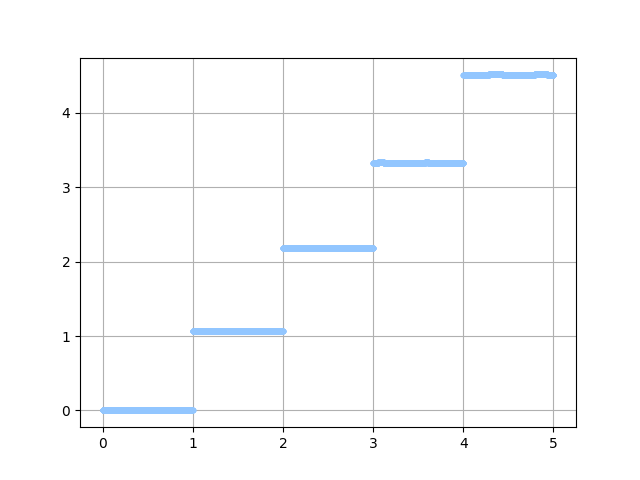

In [49]:
res = []
length = 10000
for k in range(length):
    c = torch.tensor(np.sqrt(2) * y0[k], requires_grad=True, dtype=torch.float64)
    res.append(ho_model(c).detach().numpy())
res = np.array(res)
a = res * dx
x_axis = np.linspace(0,length - 1,length)
plt.plot(x_axis / 2000, a - a[0],'.')
plt.grid()

<IPython.core.display.Javascript object>


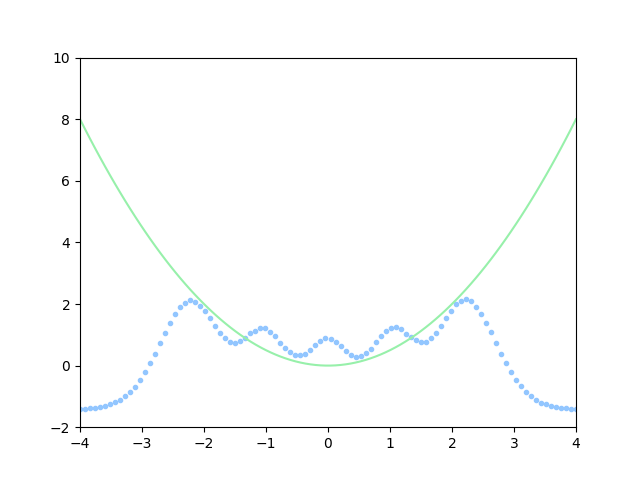

In [53]:
k=0
c = torch.tensor(np.sqrt(2) * y0[k], requires_grad=True, dtype=torch.float64)
v = torch.autograd.functional.hessian(ho_model,c)

v_diag = np.diag(v.numpy())
vv = v_diag[0:100] + v_diag[100:]
plt.plot(line_x, 0.5*(vv / dx - min(vv/dx) - 2.8), '.')
plt.plot(line_x, 0.5 * line_x**2)
plt.xlim(-4,4)
plt.ylim(-2,10)
plt.show()

<IPython.core.display.Javascript object>


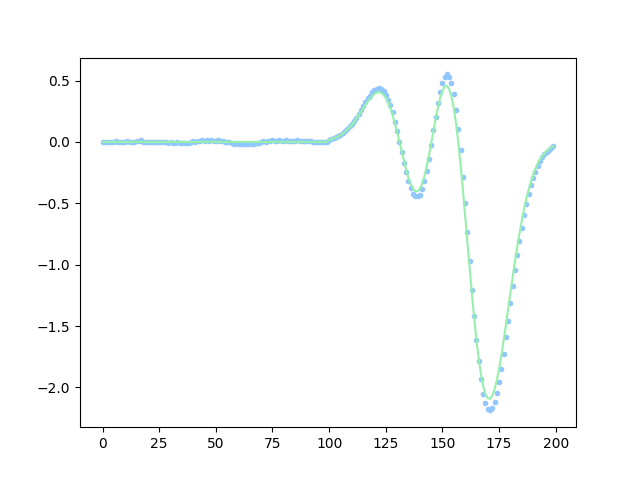

In [54]:
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
import numpy.polynomial.hermite as Herm
import math
import numpy
m=1.
w=1.
hbar=1.
#Discretized space

x_lim = 4
x = np.linspace(-x_lim, x_lim, 100)
dx = x[1] - x[0]
def hermite(x, n):
    xi = numpy.sqrt(m*w/hbar)*x
    herm_coeffs = numpy.zeros(n+1)
    herm_coeffs[n] = 1
    return Herm.hermval(xi, herm_coeffs)
  
def stationary_state(x,n):
    xi = numpy.sqrt(m*w/hbar)*x
    prefactor = 1./math.sqrt(2.**n * math.factorial(n)) * (m*w/(numpy.pi*hbar))**(0.25)
    psi = prefactor * numpy.exp(- xi**2 / 2) * hermite(x,n)
    return psi

T = np.linspace(0,30,30000)
psi_0 = stationary_state(x,0)
psi_1 = stationary_state(x,1)
psi_2 = stationary_state(x,2)
psi_3 = stationary_state(x,3)
init_wf = 1 / np.sqrt(2) * psi_0 + 1 / 2 * psi_1 + 1 / np.sqrt(6) * psi_2 + 1 / np.sqrt(12) * psi_3
def E_n(n):
    return (n + 1/2)*w
wf_t = []
wf_dt = []
for t in T:
    wf_t.append(1 / np.sqrt(2) * psi_0 * np.exp(-1j*E_n(0)*t) + 1 / 2 * psi_1* np.exp(-1j*E_n(1)*t) + 1 / np.sqrt(6) * psi_2* np.exp(-1j*E_n(2)*t) + 1 / np.sqrt(12) * psi_3* np.exp(-1j*E_n(3)*t))
    wf_dt.append(1 / np.sqrt(2) * -1j*E_n(0)*psi_0 * np.exp(-1j*E_n(0)*t) + -1j*E_n(1)*1 / 2 * psi_1* np.exp(-1j*E_n(1)*t) + -1j*E_n(2)*1 / np.sqrt(6) * psi_2* np.exp(-1j*E_n(2)*t) + -1j*E_n(3)*1 / np.sqrt(12) * psi_3* np.exp(-1j*E_n(3)*t))
    

qq = np.real(wf_t)
pp = np.imag(wf_t)
q_p = torch.tensor(np.hstack((qq, pp)),
                         requires_grad=True, dtype=torch.float32).to(device)
q_dt = np.real(wf_dt)
p_dt = np.imag(wf_dt)
q_p_dt = torch.tensor(np.hstack((q_dt, p_dt)),
                         requires_grad=True, dtype=torch.float32).to(device)

k= 0
ho_model = ho_model.float().to(device)
ho_dt = ho_model.time_derivative(np.sqrt(2)*q_p[k]).cpu().detach().numpy()
comp = np.sqrt(2)*q_p_dt[k].cpu().detach().numpy()
# plt.plot(q_p[k].detach().numpy())
plt.plot(ho_dt,'.')
plt.plot(comp)

<IPython.core.display.Javascript object>


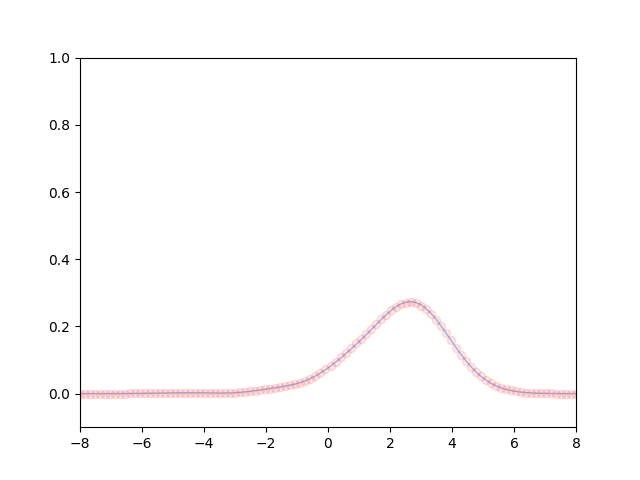

In [55]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
# plt.style.use('seaborn-pastel')
# matplotlib.rcParams['animation.embed_limit'] = 2**128

length = 100
xmax = 8
dens = 0.5*(q_p[:,0:length].cpu()**2 + q_p[:, length:].cpu()**2)
dens = dens.detach().numpy()
dens_nn = 0.5 * (hnn_x[:,0:length]**2 + hnn_x[:,length:]**2) 
fig = plt.figure()
ax = plt.axes(xlim=(-xmax, xmax), ylim=(-0.1, 1))

x = np.linspace(-6, 6, length)
line, = ax.plot(x, dens[0,:], lw= 1)
line2, = ax.plot(x, dens_nn[0,:], 'ro', alpha=0.1)
def init():
    x = np.linspace(-xmax, xmax, length)
    line.set_data(x, dens[0,:])
    line2.set_data(x, dens_nn[0,:])
    return line, line2,
def animate(i):
    x = np.linspace(-xmax, xmax, length)
    y = dens[i,:]
    z = dens_nn[i,:]
    line.set_data(x, y)
    line2.set_data(x, z)
    return line, line2,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=4000, interval=1, blit=True)

# from IPython.display import HTML
# HTML(anim.to_jshtml())